<a href="https://colab.research.google.com/github/Dicti93/MLSEM/blob/master/3.%20Data%20Preparation/Data_Prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [180]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import KNNImputer

# Display Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', 240)

In [181]:
# Create dataset
!wget 'https://raw.githubusercontent.com/Dicti93/MLSEM/master/2.%20Data%20and%20Description/data.csv' -O data.csv

# Load the downloaded CSV files into pandas DataFrames
data = pd.read_csv('data.csv', delimiter=';')

X = data.drop('Diagnosis', axis=1)  # Features
y = data['Diagnosis']               # Target variable
data.shape

--2024-04-29 18:45:16--  https://raw.githubusercontent.com/Dicti93/MLSEM/master/2.%20Data%20and%20Description/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 188851 (184K) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>] 184.42K  --.-KB/s    in 0.03s   

2024-04-29 18:45:16 (6.33 MB/s) - ‘data.csv’ saved [188851/188851]



(782, 69)

In [182]:
# deleting not needed target variables from data
data = data.drop(['Management', 'Severity', 'Diagnosis_Presumptive', 'US_Number', 'Unnamed: 58', 'Unnamed: 59', 'Unnamed: 60', 'Unnamed: 61',
                  'Unnamed: 62', 'Unnamed: 63' ,'Unnamed: 64', 'Unnamed: 65', 'Unnamed: 66', 'Unnamed: 67', 'Unnamed: 68'], axis=1)
data.shape

(782, 54)

In [183]:
# removing all NAN values from diagnosis
data = data.dropna(subset=['Diagnosis'])
data.shape

(780, 54)

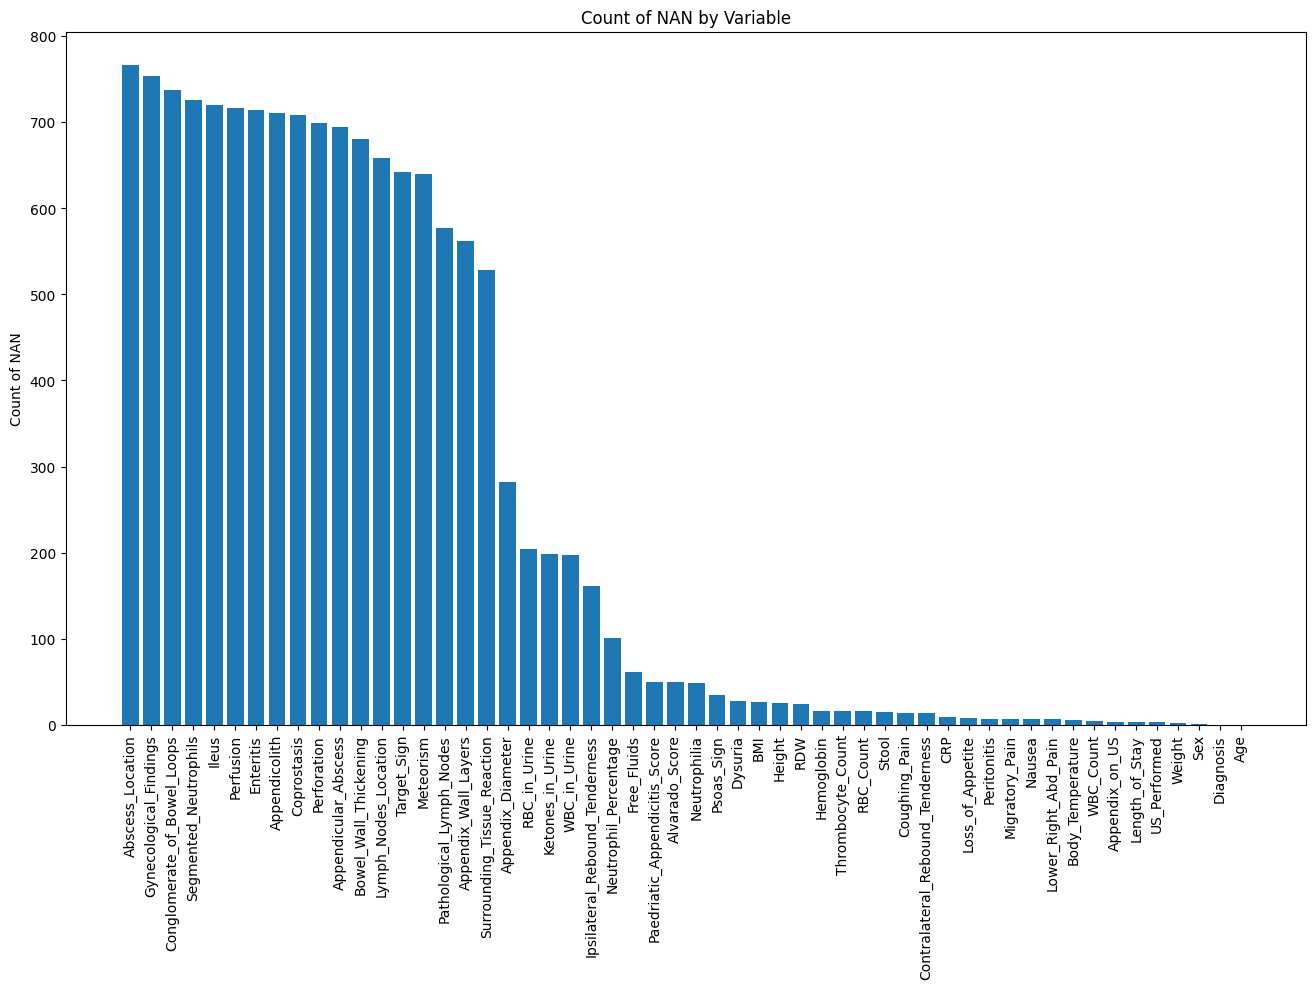

In [184]:
# visualizing count of NAN values
nan_counts = data.isna().sum()
nan_counts_sorted = nan_counts.sort_values(ascending=False)  # Sort values in descending order

plt.figure(figsize=(16, 9))
plt.bar(nan_counts_sorted.index, nan_counts_sorted.values)
plt.xticks(rotation=90)
plt.title('Count of NAN by Variable')
plt.ylabel('Count of NAN')
plt.show()

## Converting Variables to numeric & basic NAN imputation

In [185]:
def convert_variables(df):
    # Demographic Variables
    df["Sex"] = df["Sex"].replace(['male', 'female', 'no'], [1, 0, np.nan])

    # Clinical Variables
    df["Peritonitis"] = df["Peritonitis"].replace({"no": 0, "local": 1, "generalized": 1})
    df["Migratory_Pain"] = df["Migratory_Pain"].replace({'yes': 1, 'no': 0})
    df["Lower_Right_Abd_Pain"].replace({'yes': 1, 'no': 0})
    df["Contralateral_Rebound_Tenderness"] = df["Contralateral_Rebound_Tenderness"].replace({'yes': 1, 'no': 0})
    df["Coughing_Pain"] = df["Coughing_Pain"].replace({'yes': 1, 'no': 0})
    df["Psoas_Sign"] = df["Psoas_Sign"].replace({'yes': 1, 'no': 0})
    df["Nausea"] = df["Nausea"].replace({'yes': 1, 'no': 0})
    df["Loss_of_Appetite"] = df["Loss_of_Appetite"].replace({'yes': 1, 'no': 0})
    df["Dysuria"] = df["Dysuria"].replace({'yes': 1, 'no': 0})
    df["Ipsilateral_Rebound_Tenderness"] = df["Ipsilateral_Rebound_Tenderness"].replace({'yes': 1, 'no': 0})
    df["Stool"] = df["Stool"].replace({'diarrhea': 1, 'normal': 0, 'constipation': 1, 'constipation, diarrhea': 1, 'no': 0})
    df["Lower_Right_Abd_Pain"] = df["Lower_Right_Abd_Pain"].replace({'yes': 1, 'no': 0})

    # Laboratory Variables
    df["Ketones_in_Urine"] = df["Ketones_in_Urine"].replace({'no': 0, '+': 1, '++': 1, '+++': 1})
    df["RBC_in_Urine"] = df["RBC_in_Urine"].replace({'no': 0, '+': 1, '++': 1, '+++': 1})
    df["WBC_in_Urine"] = df["WBC_in_Urine"].replace({'no': 0, '+': 1, '++': 1, '+++': 1})
    df["Neutrophilia"] = df["Neutrophilia"].replace({'yes': 1, 'no': 0})

    # Ultrasound Variables
    df["US_Performed"] = df["US_Performed"].replace({'yes': 1, 'no': 0})
    df["Appendix_on_US"] = df["Appendix_on_US"].replace({'yes': 1, 'no': 0})
    df["Free_Fluids"] = df["Free_Fluids"].replace({'yes': 1, 'no': 0})
    df["Appendix_Wall_Layers"] = df["Appendix_Wall_Layers"].replace({"intact": 0, "no": 0, "raised": 1, "partially raised": 1, "upset": 1})
    df['Target_Sign'] = df['Target_Sign'].replace({'yes': 1, 'no': 0})
    df["Perfusion"] = df["Perfusion"].replace({"no": 0, "present": 1, "hypoperfused": 0, "hyperperfused": 1})
    df["Perforation"] = df["Perforation"].replace({"no": 0, "suspected": 1, "not excluded": np.nan, "yes": 1})
    df["Surrounding_Tissue_Reaction"] = df["Surrounding_Tissue_Reaction"].replace({'yes': 1, 'no': 0})
    df["Pathological_Lymph_Nodes"] = df["Pathological_Lymph_Nodes"].replace({'yes': 1, 'no': 0})
    df["Bowel_Wall_Thickening"] = df["Bowel_Wall_Thickening"].replace({'yes': 1, 'no': 0})
    df["Ileus"] = df["Ileus"].replace({'yes': 1, 'no': 0})
    df["Coprostasis"] = df["Coprostasis"].replace({'yes': 1, 'no': 0})
    df["Meteorism"] = df["Meteorism"].replace({'yes': 1, 'no': 0})
    df["Enteritis"] = df["Enteritis"].replace({'yes': 1, 'no': 0})
    df["Appendicular_Abscess"] = df["Appendicular_Abscess"].replace({"no": 0, "suspected": 1, "yes": 1})
    df["Conglomerate_of_Bowel_Loops"] = df["Conglomerate_of_Bowel_Loops"].replace({'yes': 1, 'no': 0})
    df["Appendicolith"] = df["Appendicolith"].replace({"no": 0, "suspected": 1, "yes": 1})
    df["Gynecological_Findings"] = df["Gynecological_Findings"].replace({'Ovarialzyste': 1,
                                                                        'Zyste Uterus': 1,
                                                                        'In beiden Ovarien Zysten darstellbar, links Ovar mit regelrechter Perfusion, rechts etwas vergrößert, keine eindeutige Perfusion nachweisbar. Retrovesikal freie Flüssigkeit mit Binnenecho': 1,
                                                                        'Ausschluss pathologischer Ovarialbefund': 1,
                                                                        'kleine Ovarzyste rechts': 1,
                                                                        'kein Anhalt für eine gynäkologische Ursache der Beschwerden': 0,
                                                                        'V. a. Ovarialtorsion': 1,
                                                                        'Ausschluss gyn. Ursache der Beschwerden': 0,
                                                                        'ja': 1,
                                                                        'keine': 0,
                                                                        'Ovarialzysten': 1,
                                                                        'Ovarialzyste re.': 1,
                                                                        'unauffällig': 0,
                                                                        'Ovarialzyste ': 1})

    # Diagnosis
    df["Diagnosis"] = df["Diagnosis"].replace({'appendicitis': 1, 'no appendicitis': 0})

    # Dropping Columns
    df.drop("Lymph_Nodes_Location", axis=1, inplace=True)
    df.drop("Abscess_Location", axis=1, inplace=True)

    return df

In [186]:
# For all ultrasound variables, NAN are replaced by 0
def impute_US(df):
    df['Appendix_Wall_Layers'] = df['Appendix_Wall_Layers'].replace({np.nan: 0})
    df['Target_Sign'] = df['Target_Sign'].replace({np.nan: 0})
    df['Perforation'] = df['Perforation'].replace({np.nan: 0})
    df['Appendicular_Abscess'] = df['Appendicular_Abscess'].replace({np.nan: 0})
    df['Conglomerate_of_Bowel_Loops'] = df['Conglomerate_of_Bowel_Loops'].replace({np.nan: 0})
    df['Enteritis'] = df['Enteritis'].replace({np.nan: 0})
    df['Appendix_on_US'] = df['Appendix_on_US'].replace({np.nan: 0})
    df['Pathological_Lymph_Nodes'] = df['Pathological_Lymph_Nodes'].replace({np.nan: 0})
    df['Ileus'] = df['Ileus'].replace({np.nan: 0})
    df['Coprostasis'] = df['Coprostasis'].replace({np.nan: 0})
    df['Meteorism'] = df['Meteorism'].replace({np.nan: 0})
    df['Gynecological_Findings'] = df['Gynecological_Findings'].replace({np.nan: 0})
    df['Surrounding_Tissue_Reaction'] = df['Surrounding_Tissue_Reaction'].replace({np.nan: 0})
    df['Free_Fluids'] = df['Free_Fluids'].replace({np.nan: 0})
    df['Bowel_Wall_Thickening'] = df['Bowel_Wall_Thickening'].replace({np.nan: 0})

    return df

In [187]:
data = convert_variables(data)
data = impute_US(data)
data.shape

(780, 52)

In [188]:
# Numeric conversions with coercion for invalid entries
for col in data.columns:
    try:
        # Attempt to convert each column to numeric after replacing commas
        data[col] = pd.to_numeric(data[col].astype(str).str.replace(',', '.'), errors='coerce')
    except ValueError as e:
        print(f"Error converting {col}: {str(e)}")

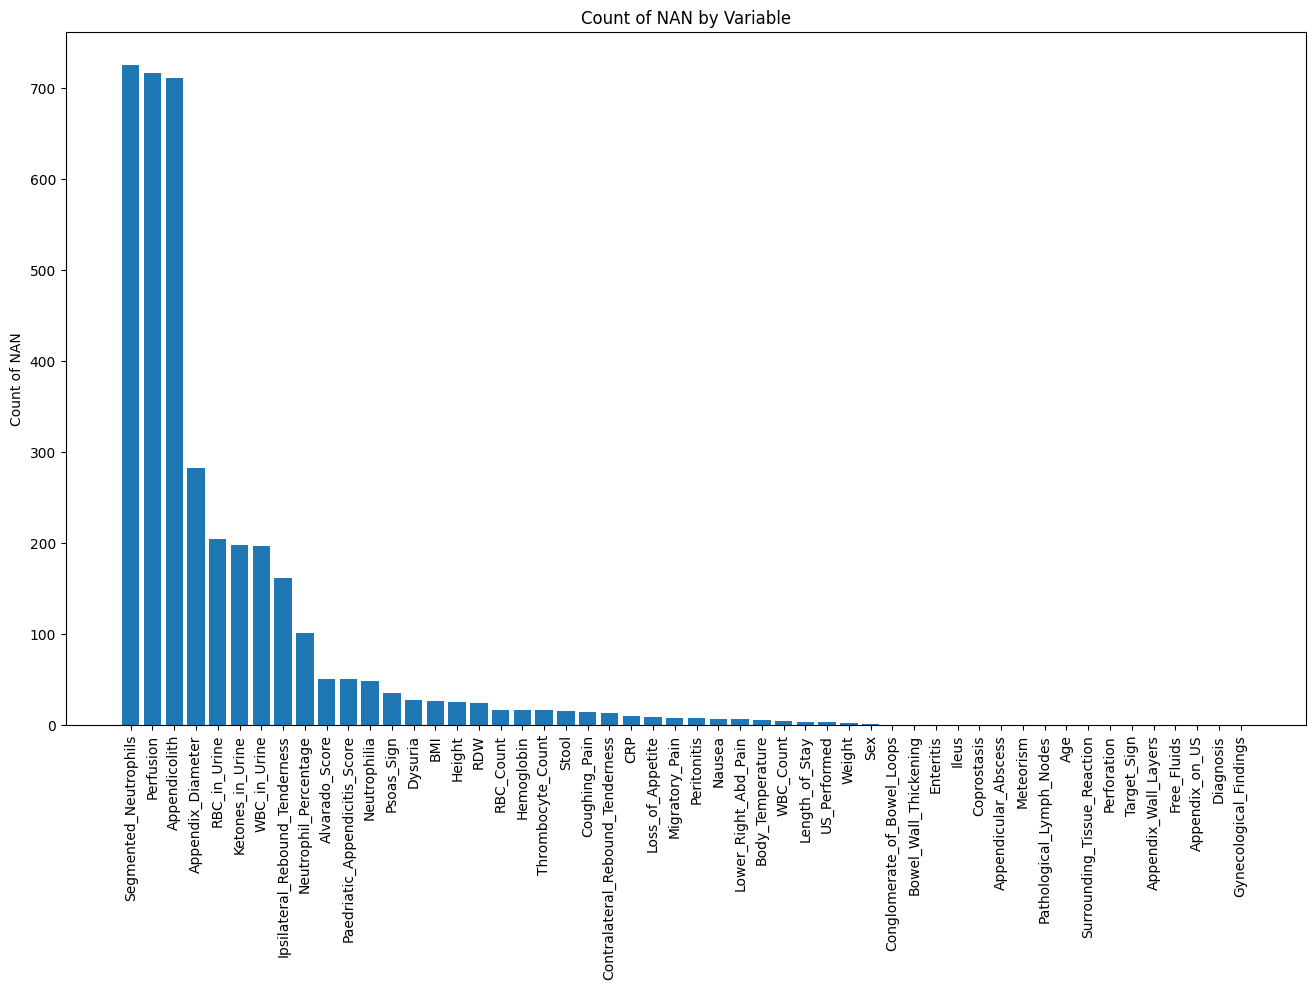

In [189]:
# visualizing count of NAN values
nan_counts = data.isna().sum()
nan_counts_sorted = nan_counts.sort_values(ascending=False)  # Sort values in descending order

plt.figure(figsize=(16, 9))
plt.bar(nan_counts_sorted.index, nan_counts_sorted.values)
plt.xticks(rotation=90)
plt.title('Count of NAN by Variable')
plt.ylabel('Count of NAN')
plt.show()

In [190]:
data.head(25)

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Diagnosis,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_on_US,Appendix_Diameter,Migratory_Pain,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,Coughing_Pain,Nausea,Loss_of_Appetite,Body_Temperature,WBC_Count,Neutrophil_Percentage,Segmented_Neutrophils,Neutrophilia,RBC_Count,Hemoglobin,RDW,Thrombocyte_Count,Ketones_in_Urine,RBC_in_Urine,WBC_in_Urine,CRP,Dysuria,Stool,Peritonitis,Psoas_Sign,Ipsilateral_Rebound_Tenderness,US_Performed,Free_Fluids,Appendix_Wall_Layers,Target_Sign,Appendicolith,Perfusion,Perforation,Surrounding_Tissue_Reaction,Appendicular_Abscess,Pathological_Lymph_Nodes,Bowel_Wall_Thickening,Conglomerate_of_Bowel_Loops,Ileus,Coprostasis,Meteorism,Enteritis,Gynecological_Findings
0,12.68,16.9,0.0,148.0,37.0,3.0,1,4.0,3.0,1.0,7.1,0.0,1.0,1.0,0.0,0.0,1.0,37.0,7.7,68.2,NaN,0.0,5.27,14.8,12.2,254.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14.10,31.9,1.0,147.0,69.5,2.0,0,5.0,4.0,0.0,NaN,1.0,1.0,1.0,0.0,0.0,1.0,36.9,8.1,64.8,NaN,0.0,5.26,15.7,12.7,151.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,14.14,23.3,0.0,163.0,62.0,4.0,0,5.0,3.0,0.0,NaN,0.0,1.0,1.0,0.0,0.0,0.0,36.6,13.2,74.8,NaN,0.0,3.98,11.4,12.2,300.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,16.37,20.6,0.0,165.0,56.0,3.0,0,7.0,6.0,0.0,NaN,1.0,1.0,0.0,0.0,1.0,1.0,36.0,11.4,63.0,NaN,0.0,4.64,13.6,13.2,258.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,11.08,16.9,0.0,163.0,45.0,3.0,1,5.0,6.0,1.0,7.0,0.0,1.0,1.0,1.0,1.0,1.0,36.9,8.1,44.0,NaN,0.0,4.44,12.6,13.6,311.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,11.05,30.7,1.0,121.0,45.0,3.0,0,6.0,7.0,0.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,36.9,9.5,71.4,NaN,0.0,4.96,12.5,13.3,249.0,1.0,0.0,0.0,63.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,8.98,19.4,0.0,140.0,38.5,3.0,0,5.0,6.0,0.0,NaN,0.0,1.0,1.0,1.0,1.0,1.0,36.7,10.0,69.1,NaN,0.0,4.77,12.7,12.6,337.0,0.0,0.0,1.0,9.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7.06,NaN,0.0,NaN,21.5,2.0,0,3.0,3.0,0.0,NaN,0.0,0.0,0.0,0.0,1.0,1.0,36.8,8.0,79.6,NaN,1.0,4.89,12.0,13.9,412.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,7.90,15.7,1.0,131.0,26.7,3.0,0,7.0,6.0,1.0,3.7,0.0,1.0,0.0,0.0,0.0,1.0,37.3,20.9,76.0,NaN,1.0,4.61,13.4,12.0,350.0,1.0,1.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,14.34,14.9,1.0,174.0,45.5,3.0,1,4.0,4.0,1.0,8.0,0.0,1.0,0.0,0.0,1.0,1.0,37.1,5.8,47.2,NaN,0.0,4.78,12.9,12.6,220.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [191]:
# Calculate BMI for NAN, when height and weight is given
missing_bmi = data['BMI'].isnull()
missing_height = data['Height'].isnull()
missing_weight = data['Weight'].isnull()

height_in_meters_squared = (data['Height'] / 100) ** 2
calculated_bmi = data['Weight'] / height_in_meters_squared * 10000
data.loc[missing_bmi, 'BMI'] = calculated_bmi[missing_bmi]

In [192]:
data.shape

(780, 52)

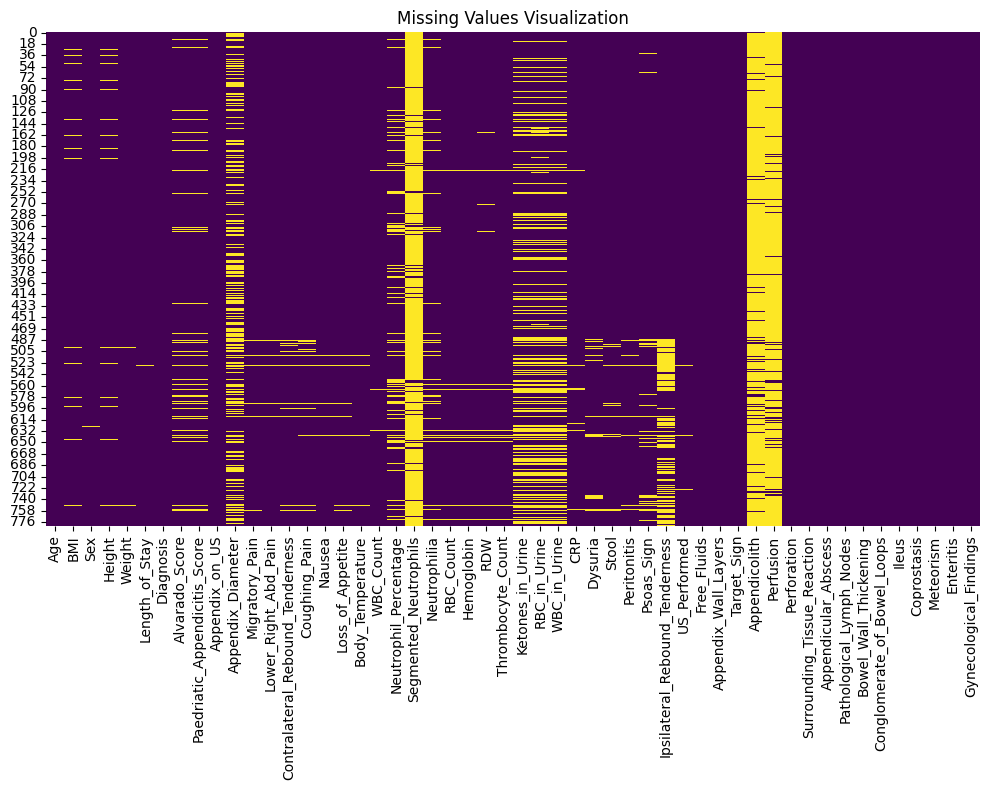

In [193]:
# Plot missing values as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Visualization')
plt.tight_layout()
plt.show()

## Filling NAN's with KNNImputer

In [194]:
imputation_knn = KNNImputer(n_neighbors=1)
full_data = imputation_knn.fit_transform(data)
full_data = pd.DataFrame(full_data, columns=data.columns)
full_data.head()

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Diagnosis,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_on_US,Appendix_Diameter,Migratory_Pain,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,Coughing_Pain,Nausea,Loss_of_Appetite,Body_Temperature,WBC_Count,Neutrophil_Percentage,Segmented_Neutrophils,Neutrophilia,RBC_Count,Hemoglobin,RDW,Thrombocyte_Count,Ketones_in_Urine,RBC_in_Urine,WBC_in_Urine,CRP,Dysuria,Stool,Peritonitis,Psoas_Sign,Ipsilateral_Rebound_Tenderness,US_Performed,Free_Fluids,Appendix_Wall_Layers,Target_Sign,Appendicolith,Perfusion,Perforation,Surrounding_Tissue_Reaction,Appendicular_Abscess,Pathological_Lymph_Nodes,Bowel_Wall_Thickening,Conglomerate_of_Bowel_Loops,Ileus,Coprostasis,Meteorism,Enteritis,Gynecological_Findings
0,12.68,16.9,0.0,148.0,37.0,3.0,1.0,4.0,3.0,1.0,7.1,0.0,1.0,1.0,0.0,0.0,1.0,37.0,7.7,68.2,46.0,0.0,5.27,14.8,12.2,254.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14.10,31.9,1.0,147.0,69.5,2.0,0.0,5.0,4.0,0.0,5.0,1.0,1.0,1.0,0.0,0.0,1.0,36.9,8.1,64.8,39.0,0.0,5.26,15.7,12.7,151.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,14.14,23.3,0.0,163.0,62.0,4.0,0.0,5.0,3.0,0.0,5.1,0.0,1.0,1.0,0.0,0.0,0.0,36.6,13.2,74.8,41.0,0.0,3.98,11.4,12.2,300.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,16.37,20.6,0.0,165.0,56.0,3.0,0.0,7.0,6.0,0.0,6.8,1.0,1.0,0.0,0.0,1.0,1.0,36.0,11.4,63.0,41.0,0.0,4.64,13.6,13.2,258.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,11.08,16.9,0.0,163.0,45.0,3.0,1.0,5.0,6.0,1.0,7.0,0.0,1.0,1.0,1.0,1.0,1.0,36.9,8.1,44.0,33.0,0.0,4.44,12.6,13.6,311.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [195]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 52 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               780 non-null    float64
 1   BMI                               780 non-null    float64
 2   Sex                               780 non-null    float64
 3   Height                            780 non-null    float64
 4   Weight                            780 non-null    float64
 5   Length_of_Stay                    780 non-null    float64
 6   Diagnosis                         780 non-null    float64
 7   Alvarado_Score                    780 non-null    float64
 8   Paedriatic_Appendicitis_Score     780 non-null    float64
 9   Appendix_on_US                    780 non-null    float64
 10  Appendix_Diameter                 780 non-null    float64
 11  Migratory_Pain                    780 non-null    float64
 12  Lower_Ri

## Outlier Detection

In [196]:
variables = [
    "Age",
    "Height",
    "Weight",
    "BMI",
    "Length_of_Stay",
    "Body_Temperature",
    "WBC_Count",
    "RBC_Count",
    "Hemoglobin",
    "RDW",
    "Thrombocyte_Count",
    "Neutrophil_Percentage",
    "Segmented_Neutrophils",
    "CRP",
    "Appendix_Diameter"
]

full_data[variables].describe()

,Age,Height,Weight,BMI,Length_of_Stay,Body_Temperature,WBC_Count,RBC_Count,Hemoglobin,RDW,Thrombocyte_Count,Neutrophil_Percentage,Segmented_Neutrophils,CRP,Appendix_Diameter
count,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000
mean,11.341831,147.836795,43.173603,286.857980,4.292308,37.401795,12.669808,4.800462,13.384615,13.166154,285.374359,71.686026,60.095128,31.573462,7.685385
std,3.529811,19.785720,17.390476,7484.227756,2.579009,0.905055,5.365560,0.497173,1.388202,4.470360,72.368163,14.593869,16.937921,57.679391,2.431541
min,0.000000,53.000000,3.960000,7.830000,1.000000,26.900000,2.600000,3.620000,8.200000,11.200000,91.000000,27.200000,32.000000,0.000000,2.700000
25%,9.197500,136.375000,29.500000,15.700000,3.000000,36.800000,8.200000,4.530000,12.600000,12.300000,236.000000,61.000000,46.000000,1.000000,6.000000
50%,11.440000,149.900000,41.300000,18.015000,3.000000,37.200000,12.000000,4.780000,13.300000,12.700000,276.000000,75.500000,62.000000,7.000000,7.550000
75%,14.040000,162.350000,54.050000,21.117500,5.000000,37.900000,16.225000,5.020000,14.000000,13.300000,330.250000,83.600000,74.000000,33.000000,9.000000
max,18.360000,192.000000,103.000000,209041.950113,28.000000,40.200000,37.700000,14.000000,36.000000,86.900000,708.000000,97.700000,91.000000,365.000000,17.000000


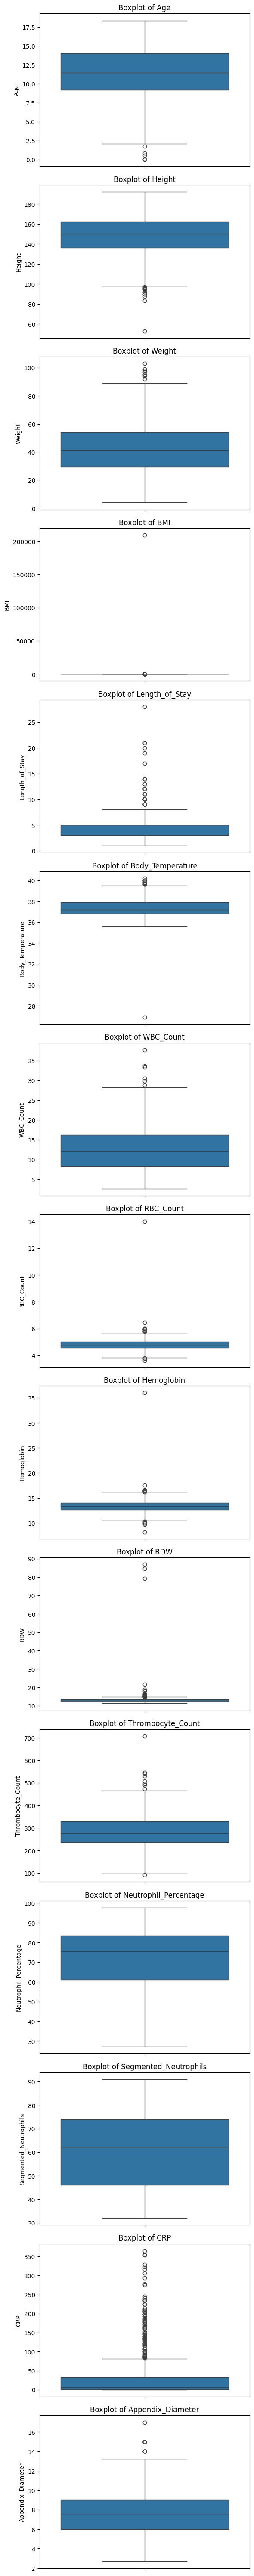

In [197]:
# Boxplots for all continuous variables
fig, axes = plt.subplots(nrows=len(variables), figsize=(6, 4 * len(variables)))

for i, var in enumerate(variables):
    sns.boxplot(full_data[var], ax=axes[i])
    axes[i].set_title(f'Boxplot of {var}')

plt.tight_layout()
plt.show()

## Winsorization
- Instead of dropping observations with outliers, we adjust the outlier value to a more reasonable value

In [198]:
# BMI
p = 0.01
q = 0.99
lower_value = full_data["BMI"].quantile(p)
upper_value = full_data["BMI"].quantile(q)
full_data.loc[:, "BMI"] = full_data["BMI"].clip(lower=lower_value, upper=upper_value)

# Body Temperature
p = 0.005
q = 1
lower_value = full_data["Body_Temperature"].quantile(p)
upper_value = full_data["Body_Temperature"].quantile(q)
full_data.loc[:, "Body_Temperature"] = full_data["Body_Temperature"].clip(lower=lower_value, upper=upper_value)

# WBC Count
p = 0.05
q = 0.95
lower_value = full_data["WBC_Count"].quantile(p)
upper_value = full_data["WBC_Count"].quantile(q)
full_data.loc[:, "WBC_Count"] = full_data["WBC_Count"].clip(lower=lower_value, upper=upper_value)

# RBC_Count
p = 0.025
q = 0.975
lower_value = full_data["RBC_Count"].quantile(p)
upper_value = full_data["RBC_Count"].quantile(q)
full_data.loc[:, "RBC_Count"] = full_data["RBC_Count"].clip(lower=lower_value, upper=upper_value)

# Hemoglobin
p = 0.025
q = 0.975
lower_value = full_data["Hemoglobin"].quantile(p)
upper_value = full_data["Hemoglobin"].quantile(q)
full_data.loc[:, "Hemoglobin"] = full_data["Hemoglobin"].clip(lower=lower_value, upper=upper_value)

# RDW
p = 0.025
q = 0.95
lower_value = full_data["RDW"].quantile(p)
upper_value = full_data["RDW"].quantile(q)
full_data.loc[:, "RDW"] = full_data["RDW"].clip(lower=lower_value, upper=upper_value)

# Thrombocyte_Count
p = 0.025
q = 0.95
lower_value = full_data["Thrombocyte_Count"].quantile(p)
upper_value = full_data["Thrombocyte_Count"].quantile(q)
full_data.loc[:, "Thrombocyte_Count"] = full_data["Thrombocyte_Count"].clip(lower=lower_value, upper=upper_value)

# Neutrophil_Percentage
p = 0.025
q = 0.975
lower_value = full_data["Neutrophil_Percentage"].quantile(p)
upper_value = full_data["Neutrophil_Percentage"].quantile(q)
full_data.loc[:, "Neutrophil_Percentage"] = full_data["Neutrophil_Percentage"].clip(lower=lower_value, upper=upper_value)

# Segmented_Neutrophils
p = 0.025
q = 0.975
lower_value = full_data["Segmented_Neutrophils"].quantile(p)
upper_value = full_data["Segmented_Neutrophils"].quantile(q)
full_data.loc[:, "Segmented_Neutrophils"] = full_data["Segmented_Neutrophils"].clip(lower=lower_value, upper=upper_value)

# CRP
p = 0.05
q = 0.95
lower_value = full_data["CRP"].quantile(p)
upper_value = full_data["CRP"].quantile(q)
full_data.loc[:, "CRP"] = full_data["CRP"].clip(lower=lower_value, upper=upper_value)

# Appendix_Diameter
p = 0.025
q = 0.95
lower_value = full_data["Appendix_Diameter"].quantile(p)
upper_value = full_data["Appendix_Diameter"].quantile(q)
full_data.loc[:, "Appendix_Diameter"] = full_data["Appendix_Diameter"].clip(lower=lower_value, upper=upper_value)

## Exporting CSV

In [203]:
full_data.to_csv('clean_data.csv', index=False)

# Colab file management to download the file to your local system
from google.colab import files
files.download('clean_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>